In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import warnings

In [3]:
train = pd.read_csv('prediction_log/train_log.csv')
test = pd.read_csv('prediction_log/test_log.csv')

In [4]:
new_train = train
new_test = test

In [5]:
new_train.drop(columns=['enroll_id', 'object'], inplace=True)
new_test.drop(columns=['enroll_id', 'object'], inplace=True)

In [6]:
# Substitute various actions with category-type actions
video_action = ['seek_video','play_video','pause_video','stop_video','load_video']
problem_action = ['problem_get','problem_check','problem_save','reset_problem','problem_check_correct', 'problem_check_incorrect']
forum_action = ['create_thread','create_comment','delete_thread','delete_comment']
click_action = ['click_info','click_courseware','click_about','click_forum','click_progress']
close_action = ['close_courseware']

video = ['video']*len(video_action)
problem = ['problem']*len(problem_action)
forum = ['forum']*len(forum_action)
click = ['click']*len(click_action)
close = ['close']*len(close_action)

video_dict = dict(zip(video_action, video))
problem_dict = dict(zip(problem_action, problem))
forum_dict = dict(zip(forum_action, forum))
click_dict = dict(zip(click_action, click))
close_dict = dict(zip(close_action, close))

new_train['action'].replace(video_dict, inplace=True)
new_train['action'].replace(problem_dict, inplace=True)
new_train['action'].replace(forum_dict, inplace=True)
new_train['action'].replace(click_dict, inplace=True)
new_train['action'].replace(close_dict, inplace=True)

new_test['action'].replace(video_dict, inplace=True)
new_test['action'].replace(problem_dict, inplace=True)
new_test['action'].replace(forum_dict, inplace=True)
new_test['action'].replace(click_dict, inplace=True)
new_test['action'].replace(close_dict, inplace=True)


### Retrieve time spent on courses from join with course_info dataframe

In [7]:
courseinfo = pd.read_csv('course_info.csv', index_col='id')

In [8]:
new_train = new_train.merge(courseinfo, on='course_id')
new_test = new_test.merge(courseinfo, on='course_id')

In [9]:
data = pd.concat([new_train, new_test], ignore_index=True)

In [10]:
data.drop(columns=['session_id', 'action', 'start', 'end', 'course_type', 'category'], inplace=True)

In [11]:
data.rename(columns={'time': 'date'}, inplace=True)
data['date'] = pd.to_datetime(data['date'])

In [12]:
data['date'] = data['date'].dt.date

In [13]:
data['count'] = len(data)*[1]

In [14]:
data = data.groupby(by=['username', 'course_id', 'date']).count().reset_index()

In [15]:
data

,username,course_id,date,count
0,5,TsinghuaX/60510102X/_,2015-10-12,11
1,5,TsinghuaX/70240183x/2015_T2,2015-09-30,43
2,5,TsinghuaX/80511503X/2015_T2,2015-11-10,8
3,5,TsinghuaX/80511503X/2015_T2,2015-11-13,50
4,5,TsinghuaX/80511503X/2015_T2,2015-11-16,1
...,...,...,...,...
673155,7011178,course-v1:TsinghuaX+AP000008X+2017T1,2017-05-05,46
673156,7019483,course-v1:TsinghuaX+20320074X+2017_T1,2017-05-11,40
673157,7023562,course-v1:TsinghuaX+AP000008X+2017T1,2017-05-12,267
673158,7036067,course-v1:TsinghuaX+AP000008X+2017T1,2017-05-15,20


In [100]:
temp = data.pivot(index=['username', 'course_id'], columns='date').fillna(0).reset_index()

In [101]:
temp.columns = temp.columns.droplevel()

In [102]:
cols = list(temp.columns)
cols[0] = 'username'
cols[1] = 'course_id'
temp.columns = cols

In [106]:
temp.drop(columns=['username', 'course_id'], inplace=True)

## Build Prophet model for platform traffic prediction

In [132]:
df_prophet_pivot = temp.T.reset_index()

In [133]:
df_prophet_pivot.rename(columns={'index':'ds'}, inplace=True)

In [134]:
df_prophet_pivot['y'] = df_prophet_pivot[list(df_prophet_pivot.columns)[1:]].sum(axis=1)

In [135]:
df_prophet_pivot

,ds,0,1,2,3,4,5,6,7,8,...,225633,225634,225635,225636,225637,225638,225639,225640,225641,y
0,2015-06-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5275.0
1,2015-06-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11399.0
2,2015-06-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13734.0
3,2015-06-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13044.0
4,2015-06-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12876.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608,2017-06-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2072.0
609,2017-06-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,739.0
610,2017-06-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1239.0
611,2017-06-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,741.0


In [169]:
final = df_prophet_pivot.drop(columns=list(df_prophet_pivot.columns)[1:-1])

In [173]:
final

,ds,y
0,2015-06-04,5275.0
1,2015-06-05,11399.0
2,2015-06-06,13734.0
3,2015-06-07,13044.0
4,2015-06-08,12876.0
...,...,...
608,2017-06-01,2072.0
609,2017-06-02,739.0
610,2017-06-03,1239.0
611,2017-06-04,741.0


In [259]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
from prophet.plot import add_changepoints_to_plot

### Model for next year prediction

In [260]:
# Provide cap and floor
final['cap'] = final['y'].max()
final['floor'] = 0
# create Prophet model with American and Chinese holidays
model = Prophet(growth = 'logistic', yearly_seasonality=True)
#model.add_country_holidays(country_name='US')
#model.add_country_holidays(country_name='China')

# fit the model
model.fit(final)

# perform forecast
future = model.make_future_dataframe(periods=365)
# set cap
future['cap'] = final['y'].max()
future['floor'] = 0
forecast = model.predict(future)

# Display forecast
display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
0,2015-06-04,23085.162580,-47413.363771,91952.559902
1,2015-06-05,16848.637370,-52955.170762,86931.814700
2,2015-06-06,18689.591724,-49080.865933,89119.898980
3,2015-06-07,23388.605770,-43186.188656,89182.407869
4,2015-06-08,29552.822787,-41089.452906,104700.232784
...,...,...,...,...
973,2018-06-01,-37255.344663,-104499.308436,29814.687026
974,2018-06-02,-35515.980924,-99284.633008,33211.014549
975,2018-06-03,-31174.685278,-99962.076147,38611.016589
976,2018-06-04,-25634.125426,-92093.320175,45996.844005


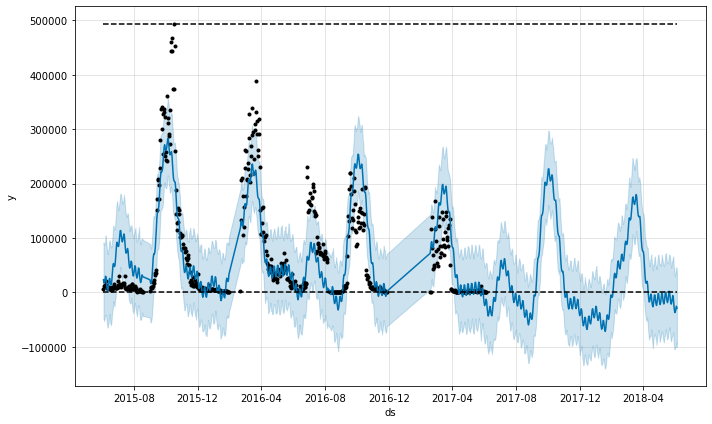

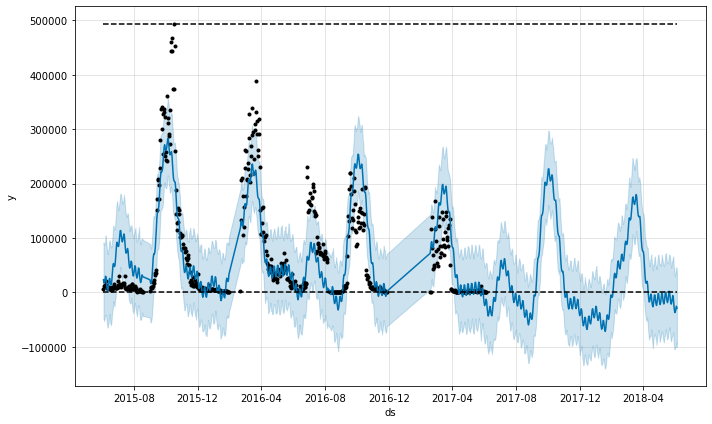

In [261]:
# Plot forecast
model.plot(forecast)

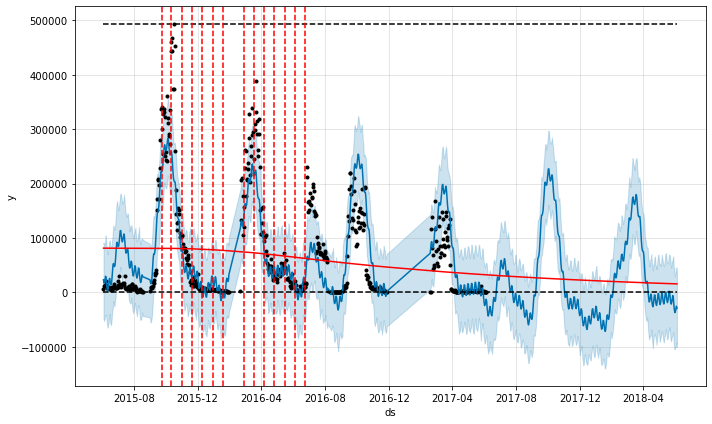

In [262]:
# Changing trend points
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

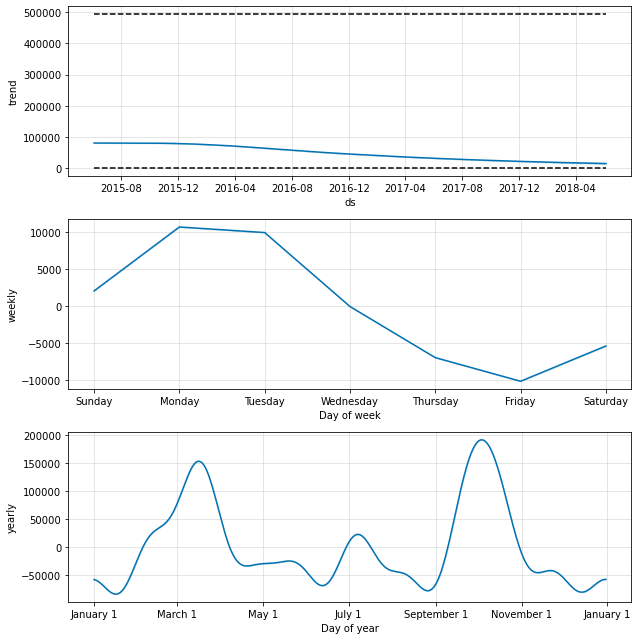

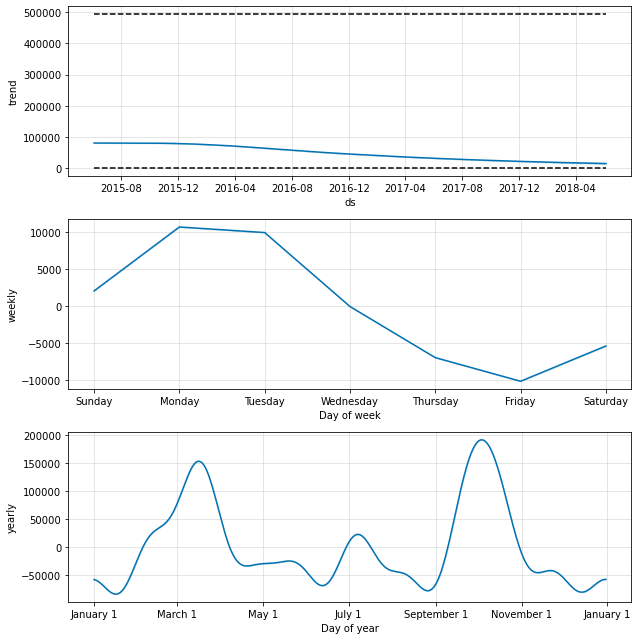

In [263]:
# Plot decomposition
model.plot_components(forecast)

#### Remove 2017 from data

In [264]:
new_final = final.iloc[:505]
# create Prophet model with American and Chinese holidays
new_model = Prophet(growth = 'logistic', yearly_seasonality=True)
#new_model.add_country_holidays(country_name='US')
#new_model.add_country_holidays(country_name='China')

# fit the model
new_model.fit(new_final)

# perform forecast
new_future = new_model.make_future_dataframe(periods=365)
# set cap
new_future['cap'] = new_final['y'].max()
new_future['floor'] = 0
new_forecast = new_model.predict(new_future)

# Display forecast
display(new_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
0,2015-06-04,10156.006228,-59038.078205,82655.551577
1,2015-06-05,3688.927836,-68348.028828,71686.252571
2,2015-06-06,7356.129345,-63933.848619,81615.457410
3,2015-06-07,12675.584922,-55094.263427,83034.089736
4,2015-06-08,16553.462587,-54462.198410,86545.858076
...,...,...,...,...
865,2017-11-23,-6110.440931,-71896.493353,62578.440377
866,2017-11-24,-10064.220677,-79248.056299,58423.480437
867,2017-11-25,-4362.272616,-72392.691162,66438.487286
868,2017-11-26,2441.300433,-71106.881043,73177.223542


In [265]:
new_final

,ds,y,cap,floor
0,2015-06-04,5275.0,493881.0,0
1,2015-06-05,11399.0,493881.0,0
2,2015-06-06,13734.0,493881.0,0
3,2015-06-07,13044.0,493881.0,0
4,2015-06-08,12876.0,493881.0,0
...,...,...,...,...
500,2016-11-23,1773.0,493881.0,0
501,2016-11-24,620.0,493881.0,0
502,2016-11-25,984.0,493881.0,0
503,2016-11-26,630.0,493881.0,0


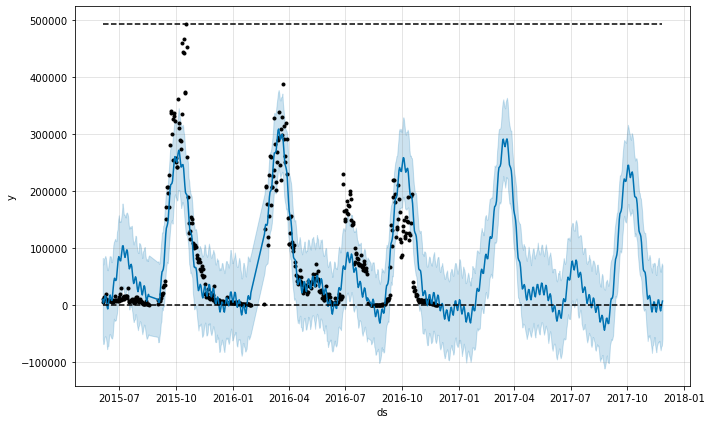

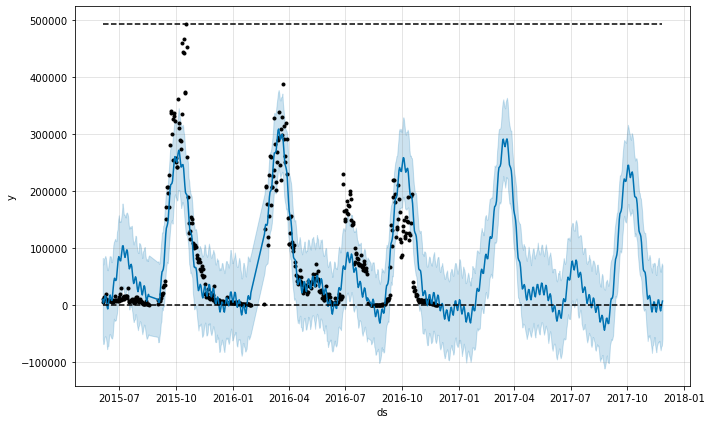

In [266]:
# Plot forecast
new_model.plot(new_forecast)

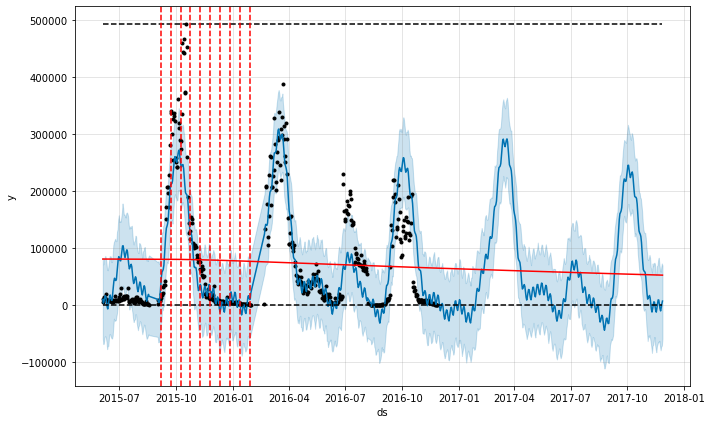

In [267]:
# Changing trend points
new_fig = new_model.plot(new_forecast)
new_a = add_changepoints_to_plot(new_fig.gca(), new_model, new_forecast)

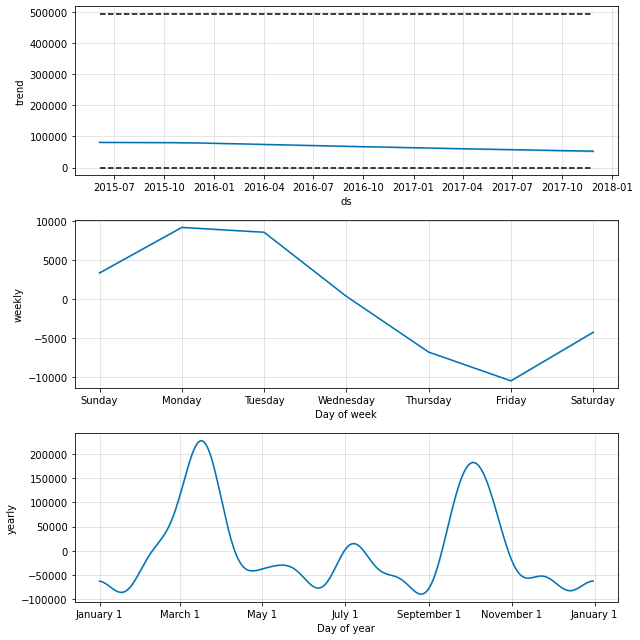

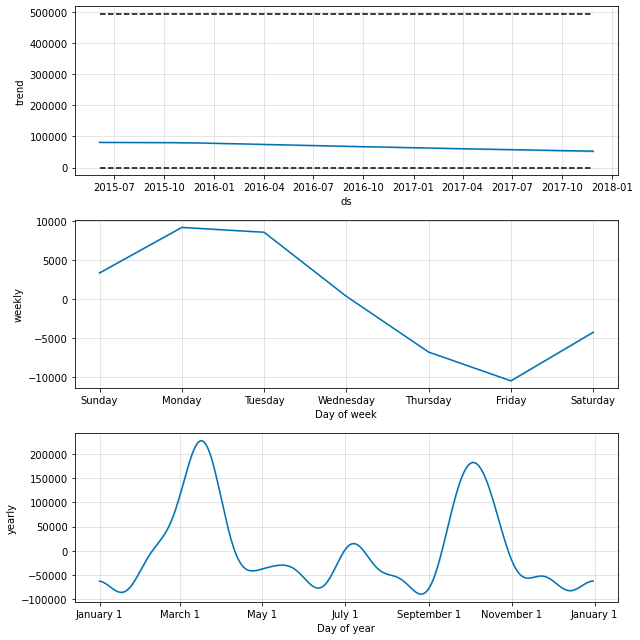

In [268]:
# Plot decomposition
new_model.plot_components(new_forecast)

### Train vs. Test

In [249]:
train = final.iloc[:333] # from June 4 2015 till June 4 2016
test = final.iloc[333:613] # from June 5 2016 till June 5 2017

In [269]:
# Provide cap and floor
train['cap'] = train['y'].max()
train['floor'] = 0
# create Prophet model with American and Chinese holidays
m = Prophet(growth = 'logistic', yearly_seasonality=True)
#model.add_country_holidays(country_name='US')
#model.add_country_holidays(country_name='China')

# fit the model
m.fit(train)

# perform forecast
fut = model.make_future_dataframe(periods=len(test))
# set cap
fut['cap'] = final['y'].max()
fut['floor'] = 0
f = model.predict(fut)

# Display forecast
display(f[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

<ipython-input-269-47b593fc2b4c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['cap'] = train['y'].max()
<ipython-input-269-47b593fc2b4c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['floor'] = 0
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
0,2015-06-04,23085.162580,-47608.844516,89929.997384
1,2015-06-05,16848.637370,-52148.809748,86944.976395
2,2015-06-06,18689.591724,-54541.622942,86321.864548
3,2015-06-07,23388.605770,-50843.910156,91867.505788
4,2015-06-08,29552.822787,-43331.281671,95738.598757
...,...,...,...,...
888,2018-03-08,132960.834517,66442.958416,204116.755581
889,2018-03-09,135895.080768,65362.774453,205733.347209
890,2018-03-10,146381.823772,79765.677684,213443.974072
891,2018-03-11,159016.783280,86967.879811,232566.396999


In [252]:
# Print MAE
y_true = test['y'].values
y_pred = forecast['yhat'][len(train):].values
mae = mean_absolute_error(y_true, y_pred)
print('Trained from June 4 2015 till June 4 2016')
print('Tested from June 5 2016 till June 5 2017')
print('MAE =', round(mae, 3))

Trained from June 4 2015 till June 4 2016
Tested from June 5 2016 till June 5 2017
MAE = 101342.551


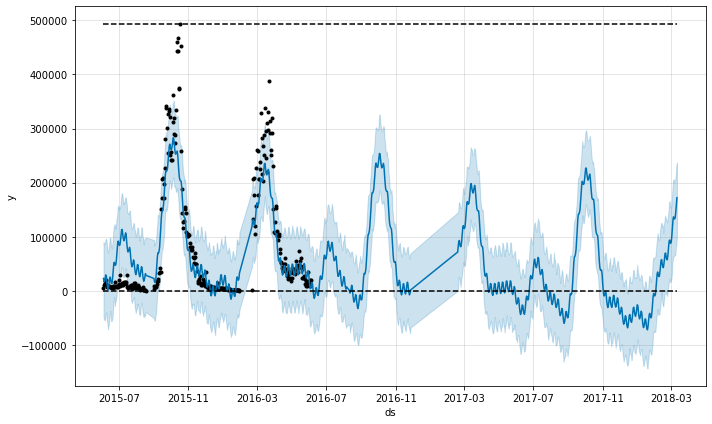

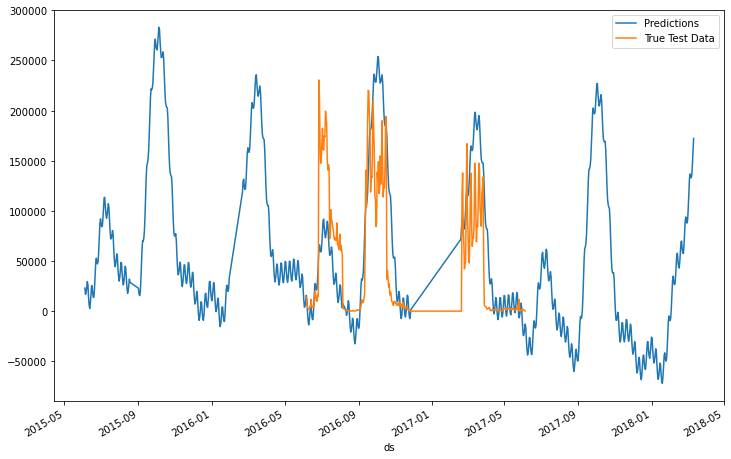

In [270]:
# Plot forecast
m.plot(f)
ax=f.plot(x='ds',y='yhat',legend=True,label='Predictions',figsize=(12,8))
test.plot(x='ds', y='y',legend=True, label='True Test Data', ax=ax)

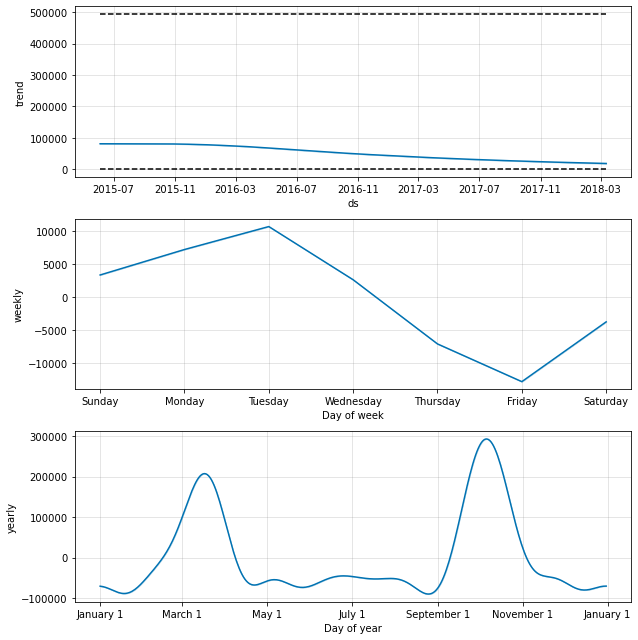

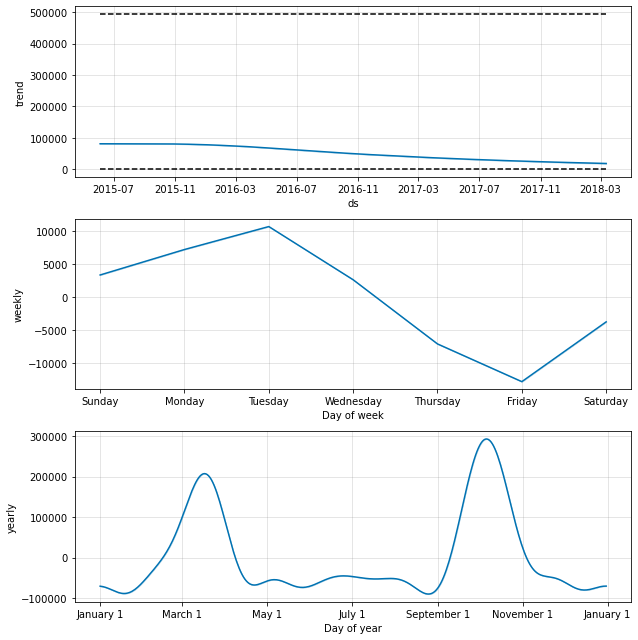

In [271]:
# Plot decomposition
m.plot_components(f)

#### Performance metrics

In [272]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

In [277]:
# Initial training period.
initial = len(train)
initial = str(initial) + ' days'

# Period length that we perform the cross validation for.
period = len(train)
period = str(period) + ' days'

# Horizon of prediction essentially for each fold.
horizon = len(test)
horizon = str(horizon) + ' days'

fb_cv = cross_validation(model, initial=initial, horizon=horizon)

# Performance Metrics of fb_cv
performance_metrics(fb_cv)

INFO:prophet:Making 1 forecasts with cutoffs between 2016-08-29 00:00:00 and 2016-08-29 00:00:00


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,19 days,4.053224e+09,63664.934284,54129.474470,9.507541,8.224511,1.265171,0.473684
1,20 days,4.066581e+09,63769.749128,54403.282619,8.577817,7.082804,1.176649,0.473684
2,21 days,4.316721e+09,65701.758977,57122.856028,7.154032,6.826724,1.094865,0.421053
3,22 days,4.883613e+09,69882.849928,61791.024731,6.485901,5.880720,1.027142,0.368421
4,23 days,6.456856e+09,80354.567259,70006.159549,5.966138,1.461876,0.982114,0.315789
...,...,...,...,...,...,...,...,...
175,276 days,9.182681e+09,95826.308141,95370.802691,77.207712,55.647992,1.904984,0.000000
176,277 days,8.924944e+09,94471.920767,93869.195153,80.508488,65.529493,1.908684,0.000000
177,278 days,8.626231e+09,92877.505687,92236.358298,80.950441,65.529493,1.909192,0.000000
178,279 days,8.342209e+09,91335.695807,90753.384704,83.822624,66.836998,1.910968,0.000000


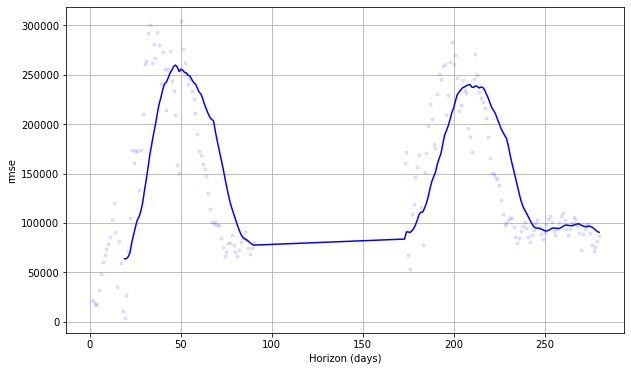

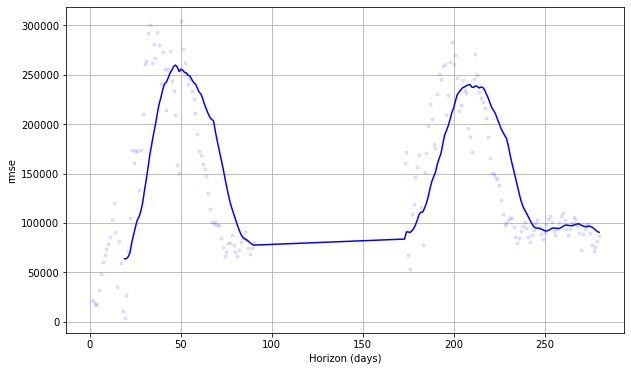

In [280]:
plot_cross_validation_metric(fb_cv,'rmse')

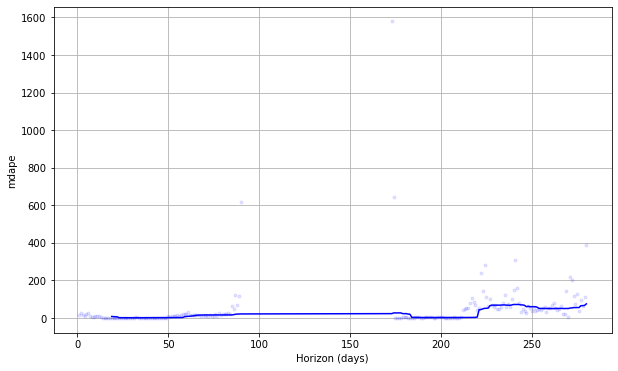

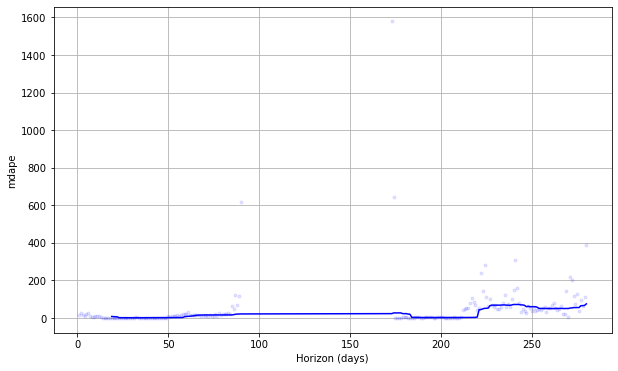

In [281]:
plot_cross_validation_metric(fb_cv,'mdape')